In [1]:
from dotenv import load_dotenv
load_dotenv()

True

### 1. 상태를 정의하기
- state 정의
- 이름이나, 대화 내용 설정

In [2]:
from typing import Annotated, TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain_openai import ChatOpenAI

# 도구
from langgraph.prebuilt.tool_node import ToolNode, tools_condition

In [3]:
# 1. tool 세팅
from langchain_tavily import TavilySearch
search_tool = TavilySearch(max_result=5)
tools = [search_tool]

# 2. State 정의
class State(TypedDict):
    messages : Annotated[list, add_messages]

# 3. LLM + tool 연결
model = ChatOpenAI(
    model = "gpt-4.1-mini",
    temperature=0
)
llm_with_tool = model.bind_tools(tools)

# 4. chatbot 노드 정의
def agent_chatbot(state : State):
    answer = llm_with_tool.invoke(state['messages'])
    return {"messages" : [answer]}

# 5. 그래프 초기화 & 노드 추가
graph_builder = StateGraph(State)
graph_builder.add_node("chatbot", agent_chatbot)

# 6. 도구 노드 생성
tool_node = ToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)

# 7-1. 조건부 엣지 설정
graph_builder.add_conditional_edges(
    source="chatbot",
    path = tools_condition,
    path_map = ["tools", END]
    # path_map = {"tools": "tools", END : END}
    )

# 7-2. 전체 엣지 설정 (나머지 부분 연결하는 것)
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

# 8. 그래프 컴파일
graph = graph_builder.compile()

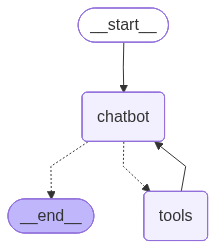

In [4]:
graph

In [ ]:
question = "2025년 석촌동민의날 축제 하는거 알아? 세부 내용도 알려줘"

for evt in graph.stream({"messages" : [("user", question)]}, stream_mode="values"):
    for key, value in evt.items():
        print("-"*30, key,"-"*30)
        value[-1].pretty_print()

------------------------------ messages ------------------------------
================================ Human Message =================================

2025년 석촌동민의날 축제 하는거 알아? 해당 축제에 대한 세부 내용을 찾아서 알려줘
------------------------------ messages ------------------------------
================================== Ai Message ==================================
Tool Calls:
  tavily_search (call_DhJmbPk9fD2MzJrdx8Z7TKM1)
 Call ID: call_DhJmbPk9fD2MzJrdx8Z7TKM1
  Args:
    query: 2025년 석촌동민의날 축제 세부 내용
------------------------------ messages ------------------------------
================================= Tool Message =================================
Name: tavily_search

{"query": "2025년 석촌동민의날 축제 세부 내용", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://karrotmarket.com/kr/community/?in=%EC%86%A1%ED%8C%8C2%EB%8F%99-416&search=%EB%B4%89%EC%82%AC%ED%99%9C%EB%8F%99", "title": "서울특별시 송파구 송파2동 이야기 | 당근 동네생활 - Karrot", "content": "10월 31일(금)부터 석촌호수에서 개최되는 송파구의 가을겨울